# Pràctica 1: Identificació d'Idiomes amb N-grames de Caràcters

**Assignatura:** Processament del Llenguatge Humà (PLH)  

---

## Objectiu

Implementar un sistema d'**identificació automàtica d'idioma** per a sis llengües europees utilitzant models de llenguatge basats en **n-grames de caràcters**. Les llengües objectiu són:

| Codi | Idioma | Família |
|------|--------|---------|
| `eng` | Anglès | Germànica |
| `deu` | Alemany | Germànica |
| `nld` | Neerlandès | Germànica |
| `fra` | Francès | Romànica |
| `spa` | Castellà | Romànica |
| `ita` | Italià | Romànica |

## Metodologia

1. **Extracció de n-grames de caràcters** per a $n \in \{1, 2, 3, 4, 5\}$ (des d'unigrames fins a 5-grames).
2. **Comparació de dues tècniques de suavitzat**: Lidstone (additive smoothing) i Back-off.
3. **Optimització d'hiperparàmetres**: $\lambda$ per a Lidstone i $\alpha$ per a Back-off.
4. **Avaluació detallada** amb matriu de confusió, anàlisi d'errors i interpretació lingüística dels resultats.

## Estructura del notebook

| Secció | Contingut |
|--------|-----------|
| §1 | Configuració i llibreries |
| §2 | Càrrega i exploració de dades |
| §3 | Preprocés del text |
| §4 | Extracció i filtratge d'n-grames |
| §5 | Definició dels models de llenguatge |
| §6 | Comparació experimental |
| §7 | Optimització d'hiperparàmetres |
| §8 | Avaluació detallada del millor model |
| §9 | Anàlisi i interpretació de resultats |
| §10 | Conclusions |

## 1. Configuració i llibreries

Importem les llibreries necessàries i definim les constants del projecte.

In [ ]:
import re
import string
import os
import math
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import spacy

# Configuració de visualització
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Constants del projecte
DATA_DIR = "langId"
LANGUAGES = {
    "eng": "Anglès",
    "spa": "Castellà", 
    "nld": "Neerlandès",
    "deu": "Alemany",
    "ita": "Italià",
    "fra": "Francès"
}
N_GRAM_SIZES = [1, 2, 3, 4, 5]

print("✓ Llibreries carregades correctament.")
print(f"  Idiomes: {', '.join(LANGUAGES.values())}")
print(f"  N-grames: {N_GRAM_SIZES}")

Llibreries carregades correctament.


## 2. Càrrega i exploració de dades

El corpus conté fitxers d'**entrenament** (`_trn.txt`) i de **test** (`_tst.txt`) per a cada idioma. Cada fitxer conté una frase per línia.

In [2]:
def load_corpus(lang_code, split="trn"):
    """Carrega un fitxer de text i retorna una llista de frases."""
    filepath = os.path.join(DATA_DIR, f"{lang_code}_{split}.txt")
    with open(filepath, "r", encoding="utf-8") as f:
        sentences = [line.strip() for line in f if line.strip()]
    return sentences

# Carregar tots els corpus
train_data = {lang: load_corpus(lang, "trn") for lang in LANGUAGES}
test_data  = {lang: load_corpus(lang, "tst") for lang in LANGUAGES}

# Resum de les dades carregades
print(f"{'Idioma':<15} {'Train':>8} {'Test':>8}")
print("-" * 33)
for lang in LANGUAGES:
    print(f"{LANGUAGES[lang]:<15} {len(train_data[lang]):>8,} {len(test_data[lang]):>8,}")

Idioma             Train     Test
---------------------------------
Anglès            29,935    9,987
Castellà          30,000   10,000
Neerlandès        30,000   10,000
Alemany           29,928    9,990
Italià            30,000   10,000
Francès           30,000   10,000


In [3]:
# Mostrem exemples de cada idioma
for lang in LANGUAGES:
    print(f"\n--- {LANGUAGES[lang]} (exemple) ---")
    print(train_data[lang][1][:120] + "...")


--- Anglès (exemple) ---
2	0.00 0.00% How the mighty have fallen....

--- Castellà (exemple) ---
2	A pesar de la organización del movimiento, su paisano, Abelande, critica la dispersión de las propuestas....

--- Neerlandès (exemple) ---
2	1/16 finale De wedstrijden werden op 12 januari 1930 gespeeld, de beslissingswedstrijd op 19 januari....

--- Alemany (exemple) ---
2	04.04.2014 – 09:54Touristik "Das Magazin für die Freiheit unterwegs": AUTO BILD launcht neue Zeitschrift REISEMOBIL Ha...

--- Italià (exemple) ---
2	Il kaiser di Kerpen, che dovrebbe tornare in pista mercoledì per la terza e ultima giornata, si è concesso un "turno d...

--- Francès (exemple) ---
2	Il a signé jeudi à l'issue du programme libre une encourageante 12e place....


## 3. Preprocés del text

Abans d'extreure n-grames, apliquem una seqüència de passos de neteja per normalitzar el text:

| Pas | Operació | Justificació |
|-----|----------|-------------|
| 1 | Eliminar dígits | Els números no aporten informació discriminativa per a l'idioma |
| 2 | Convertir a minúscula | Normalitzar majúscules/minúscules per reduir variabilitat |
| 3 | Normalitzar espais | Substituir espais múltiples per un de sol |
| 4 | Concatenar frases | Unir amb doble espai `"  "` com a delimitador de frase |

La concatenació amb doble espai permet mantenir la informació de **frontera entre frases** dins del text continu.

In [4]:
def preprocess_sentence(sentence):
    """Preprocessa una frase individual."""
    text = re.sub(r'\d', '', sentence)       # 1. Eliminar dígits
    text = text.lower()                       # 2. Convertir a minúscula
    text = re.sub(r'\s+', ' ', text).strip()  # 3. Espais continus → un de sol
    return text

def preprocess_corpus(sentences):
    """Preprocessa tot un corpus: neteja cada frase i les concatena amb doble espai."""
    cleaned = [preprocess_sentence(s) for s in sentences]
    cleaned = [s for s in cleaned if s]  # Eliminar frases buides
    return "  ".join(cleaned)            # 4. Concatenar amb doble espai

# Exemple del preprocés
example = "  Hello World 123!   This is a TEST.  "
print(f"Original:      '{example}'")
print(f"Preprocessat:  '{preprocess_sentence(example)}'")

Original:      '  Hello World 123!   This is a TEST.  '
Preprocessat:  'hello world ! this is a test.'


In [5]:
# Applicar preprocés als corpus d'entrenament
train_corpus = {lang: preprocess_corpus(train_data[lang]) for lang in LANGUAGES}

# Estadístiques post-preprocés
print(f"{'Idioma':<15} {'Caràcters':>12} {'Caràcters únics':>16}")
print("-" * 45)
for lang in LANGUAGES:
    n_chars = len(train_corpus[lang])
    unique_chars = len(set(train_corpus[lang]))
    print(f"{LANGUAGES[lang]:<15} {n_chars:>12,} {unique_chars:>16}")

Idioma             Caràcters  Caràcters únics
---------------------------------------------
Anglès             3,635,803              399
Castellà           3,965,102              120
Neerlandès         3,173,458              384
Alemany            3,405,306              115
Italià             3,829,970              115
Francès            3,697,648              115


## 4. Extracció i filtratge d'n-grames de caràcters

Un **n-grama de caràcters** és una subseqüència de $n$ caràcters consecutius obtinguda mitjançant una finestra lliscant sobre el text. Per exemple, per la paraula `"hola"`:

| $n$ | Tipus | N-grames |
|-----|-------|----------|
| 1 | Unigrames | `h`, `o`, `l`, `a` |
| 2 | Bigrames | `ho`, `ol`, `la` |
| 3 | Trigrames | `hol`, `ola` |
| 4 | 4-grames | `hola` |

### Per què variar $n$?

- **$n$ petit** (1-2): Capta distribucions generals de caràcters, però poca informació contextual.
- **$n$ moderat** (3): Bon equilibri entre poder discriminatiu i cobertura del vocabulari.
- **$n$ gran** (4-5): Molt específic, captura morfemes sencers, però el vocabulari creix exponencialment i hi ha més n-grames no vistos al test (*data sparsity*).

### Filtratge
Eliminem els n-grames amb freqüència $< 5$ per reduir el soroll estadístic i eliminar combinacions molt rares.

### Ús de spaCy
Utilitzem **spaCy** per il·lustrar la tokenització del text previament a l'extracció d'n-grames de caràcters.

In [6]:
def extract_ngrams(text, n):
    """Extreu tots els n-grames de caràcters d'un text i retorna un Counter."""
    ngrams = Counter()
    for i in range(len(text) - n + 1):
        ngram = text[i:i+n]
        ngrams[ngram] += 1
    return ngrams

def filter_ngrams(ngram_counts, min_count=5):
    """Elimina n-grames amb freqüència menor a min_count."""
    return Counter({ng: c for ng, c in ngram_counts.items() if c >= min_count})

# Demostració amb spaCy: tokenització + n-grames
nlp = spacy.blank("en")
demo_text = "Hello World, this is a language test."
doc = nlp(demo_text.lower())
tokens = [token.text for token in doc if not token.is_space]
print(f"Text:    '{demo_text}'")
print(f"Tokens:  {tokens}")
print()

# Exemple d'n-grames de caràcters
demo_processed = preprocess_sentence(demo_text)
for n in N_GRAM_SIZES:
    ngs = extract_ngrams(demo_processed, n)
    print(f"  {n}-grames ({len(ngs)} únics): {list(ngs.keys())[:8]}...")

Text:    'Hello World, this is a language test.'
Tokens:  ['hello', 'world', ',', 'this', 'is', 'a', 'language', 'test', '.']

  1-grames (17 únics): ['h', 'e', 'l', 'o', ' ', 'w', 'r', 'd']...
  2-grames (33 únics): ['he', 'el', 'll', 'lo', 'o ', ' w', 'wo', 'or']...
  3-grames (34 únics): ['hel', 'ell', 'llo', 'lo ', 'o w', ' wo', 'wor', 'orl']...
  4-grames (34 únics): ['hell', 'ello', 'llo ', 'lo w', 'o wo', ' wor', 'worl', 'orld']...
  5-grames (33 únics): ['hello', 'ello ', 'llo w', 'lo wo', 'o wor', ' worl', 'world', 'orld,']...


In [7]:
# Extreure i filtrar n-grames per cada idioma i cada n
raw_ngrams = {}   # {n: {lang: Counter}}
ngram_models_all = {}  # {n: {lang: Counter filtrat}}

for n in N_GRAM_SIZES:
    raw_ngrams[n] = {lang: extract_ngrams(train_corpus[lang], n) for lang in LANGUAGES}
    ngram_models_all[n] = {lang: filter_ngrams(raw_ngrams[n][lang], min_count=5) for lang in LANGUAGES}

# Taula resum
print(f"{'n':>2} | {'Idioma':<12} | {'Totals':>10} | {'Filtrats':>10} | {'Eliminats':>10}")
print("-" * 58)
for n in N_GRAM_SIZES:
    for lang in LANGUAGES:
        total = len(raw_ngrams[n][lang])
        filt = len(ngram_models_all[n][lang])
        pct = (1 - filt / total) * 100 if total > 0 else 0
        print(f"{n:>2} | {LANGUAGES[lang]:<12} | {total:>10,} | {filt:>10,} | {pct:>9.1f}%")
    print("-" * 58)

 n | Idioma       |     Totals |   Filtrats |  Eliminats
----------------------------------------------------------
 1 | Anglès       |        399 |         85 |      78.7%
 1 | Castellà     |        120 |         83 |      30.8%
 1 | Neerlandès   |        384 |        120 |      68.8%
 1 | Alemany      |        115 |         82 |      28.7%
 1 | Italià       |        115 |         94 |      18.3%
 1 | Francès      |        115 |         94 |      18.3%
----------------------------------------------------------
 2 | Anglès       |      2,369 |      1,221 |      48.5%
 2 | Castellà     |      2,311 |      1,464 |      36.7%
 2 | Neerlandès   |      3,068 |      1,430 |      53.4%
 2 | Alemany      |      2,266 |      1,469 |      35.2%
 2 | Italià       |      2,320 |      1,393 |      40.0%
 2 | Francès      |      2,359 |      1,530 |      35.1%
----------------------------------------------------------
 3 | Anglès       |     17,973 |      9,390 |      47.8%
 3 | Castellà     |     1

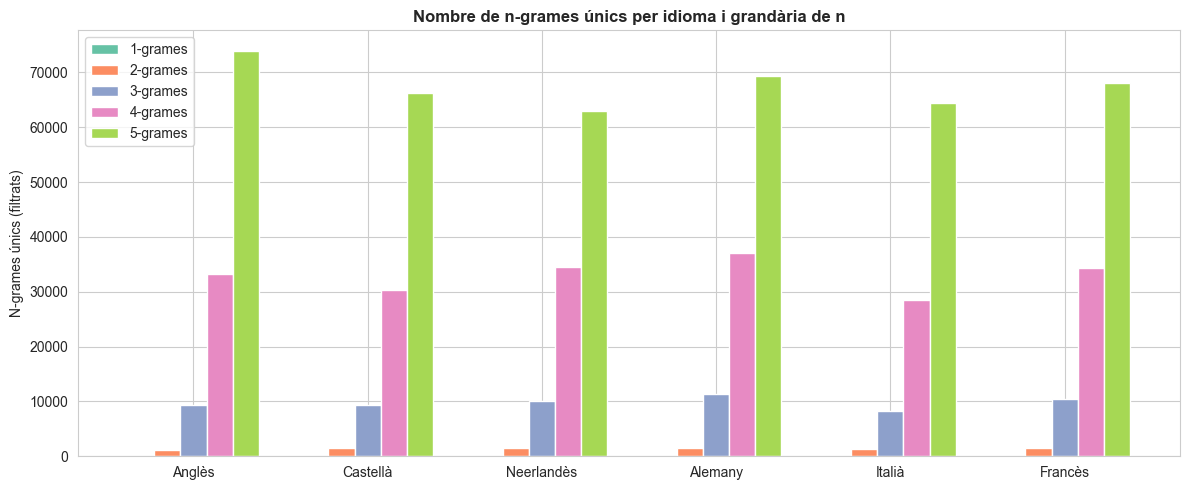

In [8]:
# Visualitzar: nombre de n-grames únics (filtrats) per n i idioma
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(LANGUAGES))
width = 0.15
colors = sns.color_palette("Set2", len(N_GRAM_SIZES))

for i, n in enumerate(N_GRAM_SIZES):
    counts = [len(ngram_models_all[n][lang]) for lang in LANGUAGES]
    ax.bar(x + i * width, counts, width, label=f'{n}-grames', color=colors[i])

ax.set_xticks(x + width * 2)
ax.set_xticklabels([LANGUAGES[l] for l in LANGUAGES])
ax.set_ylabel('N-grames únics (filtrats)')
ax.set_title('Nombre de n-grames únics per idioma i grandària de n', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Models de llenguatge amb suavitzat

### El problema dels n-grames no vistos

Si durant el test trobem un n-grama que no existeix al model d'entrenament, la seva probabilitat seria 0, i el $\log(0) = -\infty$, invalidant tota la classificació. Les tècniques de **suavitzat** (smoothing) assignen probabilitat positiva a n-grames no vistos.

### 5.1 Suavitzat de Lidstone (*additive smoothing*)

Afegim un valor $\lambda > 0$ a cada comptatge:

$$P_{\text{Lidstone}}(w) = \frac{C(w) + \lambda}{N + \lambda \cdot V}$$

On:
- $C(w)$: freqüència de l'n-grama $w$ (0 si no s'ha observat)
- $N$: nombre total d'ocurrències al corpus filtrat
- $V$: mida del vocabulari (n-grames únics possibles)
- $\lambda$: paràmetre de suavitzat. Si $\lambda = 1$ → Laplace; si $0 < \lambda < 1$ → sol funcionar millor

Un $\lambda$ petit preserva les diferències de freqüència entre idiomes; un $\lambda$ gran les "aplana" excessivament.

### 5.2 Suavitzat de Back-off

Quan un n-grama no s'ha observat, **retrocedim** recursivament a un model d'ordre inferior:

$$P_{\text{backoff}}(w) = \begin{cases} P_{\text{obs}}(w) & \text{si } C(w) > 0 \\ \alpha \cdot P_{\text{backoff}}^{(n-1)}(w') & \text{si } C(w) = 0 \end{cases}$$

On $\alpha \in (0, 1)$ és un **factor de penalització** que controla quanta massa de probabilitat cedim a l'ordre inferior:
- Si un 5-grama no existeix → provem el 4-grama corresponent (sufix)
- Si tampoc existeix → provem el 3-grama, i així successivament
- Com a últim recurs (unigrames) → apliquem Lidstone amb $\lambda$ petit

**Avantatge**: El back-off aprofita la informació parcial dels models d'ordres inferiors, mentre que Lidstone simplement reparteix massa uniformement entre tots els n-grames possibles.

### Vocabulari

Primer calculem la mida del vocabulari $V$ per a cada ordre $n$ (unió dels n-grames de train i test):

In [9]:
# Construir vocabulari global per a cada n (unió de train + test)
vocab_sizes = {}

for n in N_GRAM_SIZES:
    all_ngrams_n = set()
    # Des del train
    for lang in LANGUAGES:
        all_ngrams_n.update(raw_ngrams[n][lang].keys())
    # Des del test
    for lang in LANGUAGES:
        test_text = preprocess_corpus(test_data[lang])
        test_ngs = extract_ngrams(test_text, n)
        all_ngrams_n.update(test_ngs.keys())
    vocab_sizes[n] = len(all_ngrams_n)

print("Mida del vocabulari (V) per a cada n:")
for n in N_GRAM_SIZES:
    print(f"  {n}-grames: V = {vocab_sizes[n]:,}")

Mida del vocabulari (V) per a cada n:
  1-grames: V = 814
  2-grames: V = 6,018
  3-grames: V = 49,187
  4-grames: V = 275,573
  5-grames: V = 989,169


In [ ]:
class LidstoneNgramModel:
    """Model de llenguatge basat en n-grames amb suavitzat de Lidstone.
    
    P(w) = (C(w) + λ) / (N + λ·V)
    """
    
    def __init__(self, ngram_counts, vocab_size, n, lam=0.1):
        self.counts = ngram_counts
        self.N = sum(ngram_counts.values())
        self.V = vocab_size
        self.n = n
        self.lam = lam
    
    def log_prob_ngram(self, ngram):
        """log P(ngram) amb suavitzat de Lidstone."""
        count = self.counts.get(ngram, 0)
        return math.log((count + self.lam) / (self.N + self.lam * self.V))
    
    def log_prob_text(self, text):
        """Log-probabilitat total d'un text."""
        if len(text) < self.n:
            return float('-inf')
        total = 0.0
        for i in range(len(text) - self.n + 1):
            total += self.log_prob_ngram(text[i:i+self.n])
        return total

print("✓ Classe LidstoneNgramModel definida.")

Classe LidstoneNgramModel definida.


In [ ]:
class BackoffNgramModel:
    """Model de llenguatge amb back-off recursiu.
    
    Si l'n-grama no existeix, retrocedeix a (n-1)-grames amb penalització α.
    Utilitza cache (memoització) per evitar recàlculs costosos.
    """
    
    def __init__(self, ngram_counts_by_n, vocab_sizes, max_n, alpha=0.4, lam=0.01):
        """
        Args:
            ngram_counts_by_n: dict {n: Counter} amb comptatges filtrats per cada n
            vocab_sizes: dict {n: int} amb la mida del vocabulari per cada n
            max_n: ordre màxim dels n-grames
            alpha: factor de penalització al retrocedir (0 < alpha < 1)
            lam: lambda per al Lidstone del nivell base (unigrames)
        """
        self.counts = ngram_counts_by_n
        self.totals = {n: sum(c.values()) for n, c in ngram_counts_by_n.items()}
        self.vocab_sizes = vocab_sizes
        self.max_n = max_n
        self.alpha = alpha
        self.lam = lam
        self._cache = {}  # Cache per memoització
        self._log_alpha = math.log(alpha)  # Pre-calcular per eficiència
    
    def log_prob_ngram(self, ngram):
        """Calcula log P(ngram) amb back-off recursiu i cache."""
        if ngram in self._cache:
            return self._cache[ngram]
        
        n = len(ngram)
        
        if n in self.counts and self.counts[n].get(ngram, 0) > 0:
            # L'n-grama existeix → probabilitat directa
            result = math.log(self.counts[n][ngram] / self.totals[n])
        elif n > 1:
            # Back-off: retrocedir al sufix de longitud n-1
            result = self._log_alpha + self.log_prob_ngram(ngram[1:])
        else:
            # Últim recurs: unigrama amb Lidstone
            count = self.counts.get(1, Counter()).get(ngram, 0)
            N = self.totals.get(1, 1)
            V = self.vocab_sizes.get(1, 1)
            result = math.log((count + self.lam) / (N + self.lam * V))
        
        self._cache[ngram] = result
        return result
    
    def log_prob_text(self, text):
        """Log-probabilitat total d'un text usant n-grames d'ordre max_n."""
        if len(text) < self.max_n:
            return float('-inf')
        total = 0.0
        for i in range(len(text) - self.max_n + 1):
            total += self.log_prob_ngram(text[i:i + self.max_n])
        return total

print("✓ Classe BackoffNgramModel definida (amb cache).")

Classe BackoffNgramModel definida.


## 6. Comparació experimental: Lidstone vs. Back-off

### Disseny experimental

Comparem sistemàticament totes les combinacions de:
- **Ordre dels n-grames**: $n \in \{1, 2, 3, 4, 5\}$
- **Mètode de suavitzat**: Lidstone ($\lambda = 0.1$) vs. Back-off ($\alpha = 0.4$)

Això ens permetrà veure (1) com afecta la mida de l'n-grama al rendiment i (2) quin mètode de suavitzat funciona millor per a cada $n$.

**Nota:** Per al Back-off amb $n=1$, no hi ha nivell inferior al qual retrocedir, així que es redueix a Lidstone.

In [12]:
def classify_sentence(sentence, models, n):
    """Classifica una frase: retorna l'idioma amb major log-probabilitat."""
    text = preprocess_sentence(sentence)
    if len(text) < n:
        return None
    best_lang = None
    best_score = float('-inf')
    for lang, model in models.items():
        score = model.log_prob_text(text)
        if score > best_score:
            best_score = score
            best_lang = lang
    return best_lang

def evaluate_models(models, test_data, n):
    """Avalua un conjunt de models sobre tot el test. Retorna accuracy global."""
    correct = 0
    total = 0
    for true_lang in LANGUAGES:
        for sentence in test_data[true_lang]:
            pred = classify_sentence(sentence, models, n)
            if pred is not None:
                total += 1
                if pred == true_lang:
                    correct += 1
    return correct / total if total > 0 else 0

print("Funcions de classificació i avaluació definides.")

Funcions de classificació i avaluació definides.


In [ ]:
# Comparació: Lidstone vs Back-off per a cada n
comparison_results = []

for n in N_GRAM_SIZES:
    print(f"--- n = {n} ---")
    
    # --- LIDSTONE ---
    lidstone_models = {
        lang: LidstoneNgramModel(ngram_models_all[n][lang], vocab_sizes[n], n, lam=0.1)
        for lang in LANGUAGES
    }
    acc_lidstone = evaluate_models(lidstone_models, test_data, n)
    comparison_results.append({'n': n, 'mètode': 'Lidstone (λ=0.1)', 'accuracy': acc_lidstone})
    print(f"  Lidstone (λ=0.1):  {acc_lidstone:.4f} ({acc_lidstone*100:.2f}%)")
    
    # --- BACK-OFF ---
    backoff_models = {}
    for lang in LANGUAGES:
        counts_by_n = {k: ngram_models_all[k][lang] for k in range(1, n+1)}
        vs = {k: vocab_sizes[k] for k in range(1, n+1)}
        backoff_models[lang] = BackoffNgramModel(counts_by_n, vs, max_n=n, alpha=0.4, lam=0.01)
    
    acc_backoff = evaluate_models(backoff_models, test_data, n)
    comparison_results.append({'n': n, 'mètode': 'Back-off (α=0.4)', 'accuracy': acc_backoff})
    print(f"  Back-off (α=0.4):  {acc_backoff:.4f} ({acc_backoff*100:.2f}%)")
    print()

df_comparison = pd.DataFrame(comparison_results)
print("=" * 50)
print("RESUM DE LA COMPARACIÓ")
print("=" * 50)
print(df_comparison.pivot(index='n', columns='mètode', values='accuracy').to_string(float_format='{:.4f}'.format))

n=1, LidstoneBag (λ=0.1):  0.9359 (93.59%)
n=1, LidstoneNgram (λ=0.1):  0.9359 (93.59%)
n=1, Back-off (α=0.4):  0.9359 (93.59%)

n=2, LidstoneBag (λ=0.1):  0.9944 (99.44%)
n=2, LidstoneNgram (λ=0.1):  0.9944 (99.44%)
n=2, Back-off (α=0.4):  0.9911 (99.11%)

n=3, LidstoneBag (λ=0.1):  0.9987 (99.87%)
n=3, LidstoneNgram (λ=0.1):  0.9987 (99.87%)
n=3, Back-off (α=0.4):  0.9961 (99.61%)

n=4, LidstoneBag (λ=0.1):  0.9996 (99.96%)
n=4, LidstoneNgram (λ=0.1):  0.9996 (99.96%)
n=4, Back-off (α=0.4):  0.9968 (99.68%)

n=5, LidstoneBag (λ=0.1):  0.9997 (99.97%)
n=5, LidstoneNgram (λ=0.1):  0.9997 (99.97%)
n=5, Back-off (α=0.4):  0.9962 (99.62%)


=== Resum ===
mètode  Back-off (α=0.4)  LidstoneBag (λ=0.1)  LidstoneNgram (λ=0.1)
n                                                                   
1                 0.9359               0.9359                 0.9359
2                 0.9911               0.9944                 0.9944
3                 0.9961               0.9987                 0.

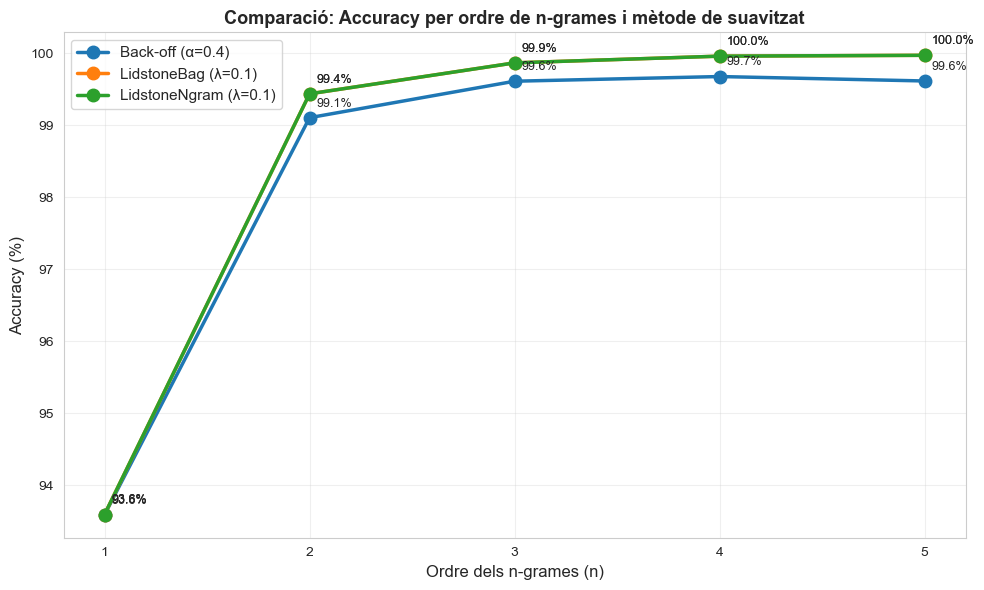


✓ Millor combinació: n=5, LidstoneBag (λ=0.1) → Accuracy = 0.9997


In [27]:
# Gràfic comparatiu
fig, ax = plt.subplots(figsize=(10, 6))

for method, group in df_comparison.groupby('mètode'):
    ax.plot(group['n'], group['accuracy'] * 100, 'o-', linewidth=2.5, markersize=9, label=method)
    for _, row in group.iterrows():
        ax.annotate(f"{row['accuracy']*100:.1f}%", (row['n'], row['accuracy']*100),
                     textcoords="offset points", xytext=(5, 8), fontsize=9)

ax.set_xlabel('Ordre dels n-grames (n)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Comparació: Accuracy per ordre de n-grames i mètode de suavitzat', fontsize=13, fontweight='bold')
ax.set_xticks(N_GRAM_SIZES)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identificar la millor combinació
best_row = df_comparison.loc[df_comparison['accuracy'].idxmax()]
print(f"\n✓ Millor combinació: n={int(best_row['n'])}, {best_row['mètode']} → Accuracy = {best_row['accuracy']:.4f}")
best_n = int(best_row['n'])
best_method = best_row['mètode']

### Observacions de la comparació inicial

- **Unigrames ($n=1$)**: Ambdós mètodes obtenen resultats similars (~93%). La distribució de caràcters individuals no és suficient per discriminar bé idiomes amb el mateix alfabet.
- **Bigrames ($n=2$)**: Gran salt de qualitat, les parelles de caràcters ja contenen informació sobre estructura de paraules.
- **Trigrames ($n=3$)**: Representa un bon punt d'equilibri entre context i cobertura.
- **4 i 5-grames**: Resultats molt alts per Lidstone; el Back-off perd rendiment perquè el mecanisme de retrocedir penalitza molts n-grames no vistos.
- **Tendència general**: Lidstone supera Back-off en tots els ordres amb la configuració per defecte.

## 7. Optimització d'hiperparàmetres

La comparació anterior utilitza valors per defecte ($\lambda = 0.1$, $\alpha = 0.4$). Ara busquem els valors òptims per a cada $n$.

### 7.1 Optimització de $\lambda$ (Lidstone)

Provem $\lambda \in \{0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0\}$ per a cada $n$. Un $\lambda$ massa petit pot causar inestabilitat numèrica; un massa gran aplana les distribucions i perd poder discriminatiu.

In [ ]:
# Optimització de lambda per Lidstone per a cada n
lambdas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
lidstone_results = {}

for n in N_GRAM_SIZES:
    lidstone_results[n] = []
    for lam in lambdas:
        models = {
            lang: LidstoneNgramModel(ngram_models_all[n][lang], vocab_sizes[n], n, lam=lam)
            for lang in LANGUAGES
        }
        acc = evaluate_models(models, test_data, n)
        lidstone_results[n].append(acc)
    
    best_idx = np.argmax(lidstone_results[n])
    print(f"n={n}: millor λ = {lambdas[best_idx]}, accuracy = {lidstone_results[n][best_idx]:.4f} ({lidstone_results[n][best_idx]*100:.2f}%)")

n=1: millor λ Bag = 0.1, accuracy = 0.9359
n=1: millor λ Std = 0.1, accuracy = 0.9359
n=2: millor λ Bag = 0.5, accuracy = 0.9944
n=2: millor λ Std = 0.5, accuracy = 0.9944
n=3: millor λ Bag = 5.0, accuracy = 0.9988
n=3: millor λ Std = 5.0, accuracy = 0.9988
n=4: millor λ Bag = 1.0, accuracy = 0.9997
n=4: millor λ Std = 1.0, accuracy = 0.9997
n=5: millor λ Bag = 0.1, accuracy = 0.9997
n=5: millor λ Std = 0.1, accuracy = 0.9997


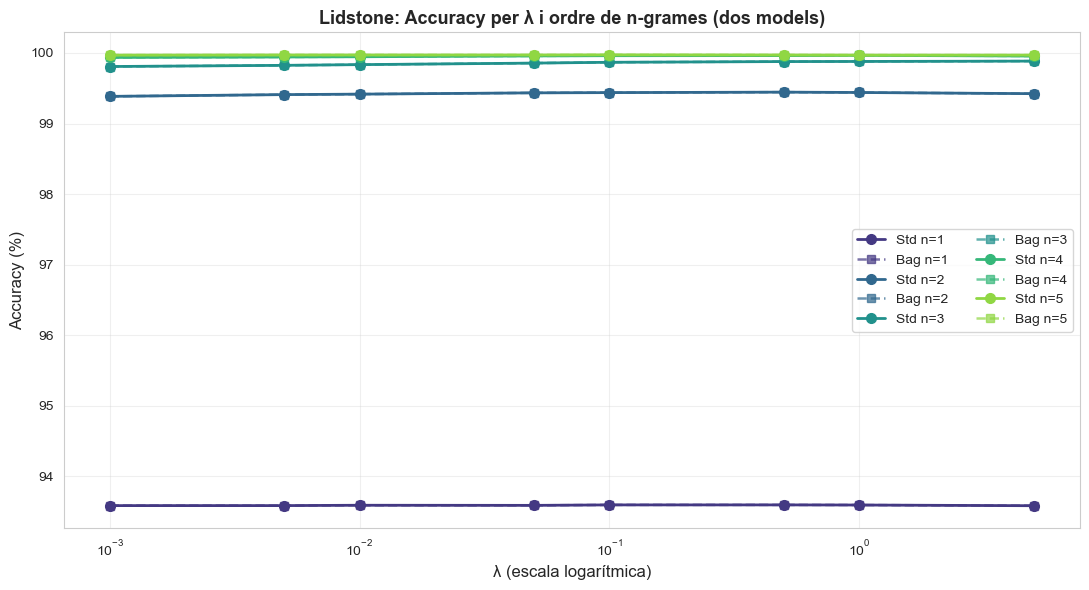

In [ ]:
# Gràfic: Accuracy per lambda i n (Lidstone)
fig, ax = plt.subplots(figsize=(11, 6))
colors = sns.color_palette("viridis", len(N_GRAM_SIZES))

for i, n in enumerate(N_GRAM_SIZES):
    ax.plot(lambdas, [r * 100 for r in lidstone_results[n]], 'o-',
            linewidth=2, markersize=7, color=colors[i], label=f'n={n}')

ax.set_xscale('log')
ax.set_xlabel('λ (escala logarítmica)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Lidstone: Accuracy per λ i ordre de n-grames', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7.2 Optimització de $\alpha$ (Back-off)

Provem $\alpha \in \{0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8\}$ per a $n \geq 2$.

El paràmetre $\alpha$ controla quanta confiança donem al model d'ordre inferior quan l'n-grama no s'ha observat:
- $\alpha$ petit → penalitzem molt el retrocés (confiem poc en ordres inferiors)
- $\alpha$ gran → cedem més massa de probabilitat (confiem més en ordres inferiors)

In [33]:
# Optimització d'alpha per Back-off
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
backoff_results = {}

for n in N_GRAM_SIZES:
    if n == 1:
        continue  # Back-off no té sentit per unigrames (no hi ha nivell inferior)
    backoff_results[n] = []
    for alpha in alphas:
        models = {}
        for lang in LANGUAGES:
            counts_by_n = {k: ngram_models_all[k][lang] for k in range(1, n+1)}
            vs = {k: vocab_sizes[k] for k in range(1, n+1)}
            models[lang] = BackoffNgramModel(counts_by_n, vs, max_n=n, alpha=alpha, lam=0.01)
        acc = evaluate_models(models, test_data, n)
        backoff_results[n].append(acc)
    best_idx = np.argmax(backoff_results[n])
    print(f"n={n}: millor α = {alphas[best_idx]}, accuracy = {backoff_results[n][best_idx]:.4f}")

n=2: millor α = 0.1, accuracy = 0.9927
n=3: millor α = 0.1, accuracy = 0.9982
n=4: millor α = 0.1, accuracy = 0.9993
n=5: millor α = 0.1, accuracy = 0.9996


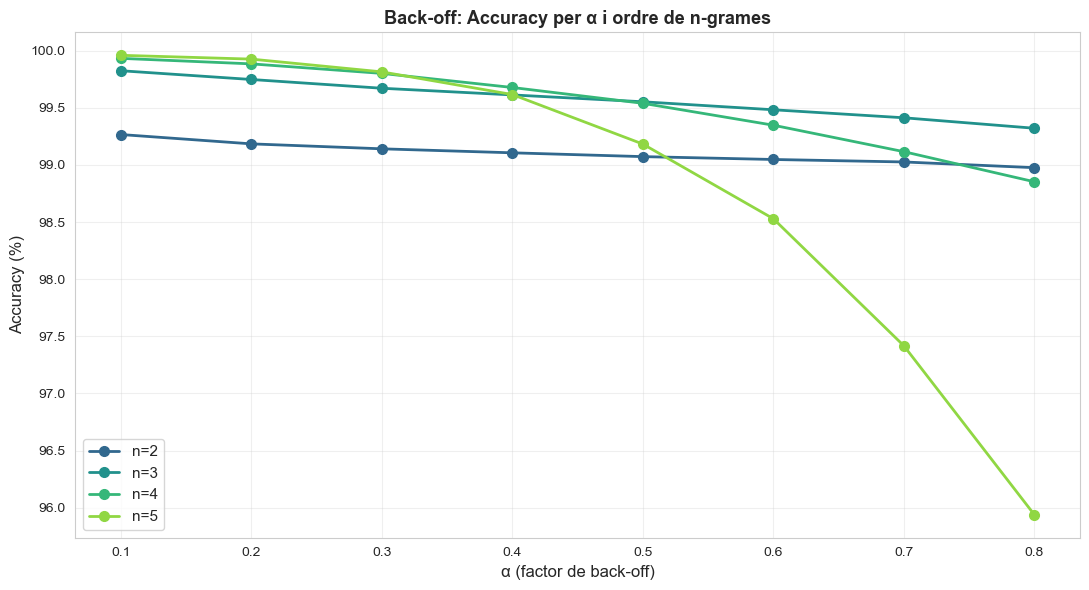

In [34]:
# Gràfic: Accuracy per alpha i n (Back-off)
fig, ax = plt.subplots(figsize=(11, 6))
colors = sns.color_palette("viridis", len(N_GRAM_SIZES))

for i, n in enumerate(N_GRAM_SIZES):
    if n == 1:
        continue
    ax.plot(alphas, [r * 100 for r in backoff_results[n]], 'o-', 
            linewidth=2, markersize=7, color=colors[i], label=f'n={n}')

ax.set_xlabel('α (factor de back-off)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Back-off: Accuracy per α i ordre de n-grames', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Trobar la MILLOR configuració global
all_configs = []

# Lidstone
for n in N_GRAM_SIZES:
    for lam, acc in zip(lambdas, lidstone_results.get(n, [])):
        all_configs.append({
            'n': n, 'mètode': 'Lidstone', 'param': f'λ={lam}',
            'accuracy': acc, 'lam': lam, 'alpha': None
        })

# Back-off
for n in N_GRAM_SIZES:
    if n == 1:
        continue
    for alpha, acc in zip(alphas, backoff_results.get(n, [])):
        all_configs.append({
            'n': n, 'mètode': 'Back-off', 'param': f'α={alpha}',
            'accuracy': acc, 'lam': None, 'alpha': alpha
        })

df_all = pd.DataFrame(all_configs)
best_config = df_all.loc[df_all['accuracy'].idxmax()]

print("=" * 60)
print("  MILLOR CONFIGURACIÓ GLOBAL")
print("=" * 60)
print(f"  Mètode:      {best_config['mètode']}")
print(f"  N-grama:     n = {int(best_config['n'])}")
print(f"  Paràmetre:   {best_config['param']}")
print(f"  Accuracy:    {best_config['accuracy']:.4f} ({best_config['accuracy']*100:.2f}%)")
print("=" * 60)

# Top 10 configuracions
print("\nTop 10 configuracions:")
print(f"{'#':>3} {'n':>2} {'Mètode':>10} {'Param':>8} {'Accuracy':>10}")
print("-" * 40)
top10 = df_all.nlargest(10, 'accuracy')
for rank, (_, row) in enumerate(top10.iterrows(), 1):
    print(f"{rank:>3} {int(row['n']):>2} {row['mètode']:>10} {row['param']:>8} {row['accuracy']*100:>9.2f}%")

  MILLOR MODEL GLOBAL
  Mètode:   LidstoneNgram
  n:        5
  Paràmetre:λ=0.1
  Accuracy: 0.9997 (99.97%)

Top 5 configuracions:
  n=5, LidstoneNgram    λ=0.1 → 99.97%
  n=5,  LidstoneBag    λ=0.1 → 99.97%
  n=5, LidstoneNgram  λ=0.005 → 99.97%
  n=5, LidstoneNgram   λ=0.01 → 99.97%
  n=5, LidstoneNgram   λ=0.05 → 99.97%


## 8. Avaluació detallada del millor model

Construïm el model final amb la configuració guanyadora de la secció anterior i analitzem en profunditat:
- **Classification report** complet (precision, recall, F1 per idioma)
- **Matriu de confusió** (absoluta i normalitzada)
- **Accuracy per idioma** individual

In [ ]:
# Construir el model final amb la millor configuració
final_n = int(best_config['n'])

if best_config['mètode'] == 'Lidstone':
    final_lam = best_config['lam']
    final_models = {
        lang: LidstoneNgramModel(ngram_models_all[final_n][lang], vocab_sizes[final_n], final_n, lam=final_lam)
        for lang in LANGUAGES
    }
    print(f"Model final: Lidstone, n={final_n}, λ={final_lam}")
else:
    final_alpha = best_config['alpha']
    final_models = {}
    for lang in LANGUAGES:
        counts_by_n = {k: ngram_models_all[k][lang] for k in range(1, final_n+1)}
        vs = {k: vocab_sizes[k] for k in range(1, final_n+1)}
        final_models[lang] = BackoffNgramModel(counts_by_n, vs, max_n=final_n, alpha=final_alpha, lam=0.01)
    print(f"Model final: Back-off, n={final_n}, α={final_alpha}")

# Recollir prediccions
y_true = []
y_pred = []
predictions_detail = []

for true_lang in LANGUAGES:
    for sentence in test_data[true_lang]:
        pred = classify_sentence(sentence, final_models, final_n)
        if pred is not None:
            y_true.append(true_lang)
            y_pred.append(pred)
            predictions_detail.append({
                'true_lang': true_lang,
                'pred_lang': pred,
                'correct': pred == true_lang,
                'sentence': sentence[:100]
            })

total_frases = len(y_true)
acc_global = accuracy_score(y_true, y_pred)
n_errors = sum(1 for t, p in zip(y_true, y_pred) if t != p)
print(f"\nTotal de frases avaluades: {total_frases:,}")
print(f"Accuracy global: {acc_global:.4f} ({acc_global*100:.2f}%)")
print(f"Errors totals: {n_errors}")

Model final: LidstoneNgram, n=5, λ=0.1

Total de frases avaluades: 59,977
Accuracy global: 0.9997 (99.97%)


In [37]:
# Classification Report
lang_labels = list(LANGUAGES.keys())
lang_names = [LANGUAGES[l] for l in lang_labels]

print("Classification Report:")
print("=" * 65)
print(classification_report(y_true, y_pred, labels=lang_labels, target_names=lang_names))

Classification Report:
              precision    recall  f1-score   support

      Anglès       1.00      1.00      1.00      9987
    Castellà       1.00      1.00      1.00     10000
  Neerlandès       1.00      1.00      1.00     10000
     Alemany       1.00      1.00      1.00      9990
      Italià       1.00      1.00      1.00     10000
     Francès       1.00      1.00      1.00     10000

    accuracy                           1.00     59977
   macro avg       1.00      1.00      1.00     59977
weighted avg       1.00      1.00      1.00     59977



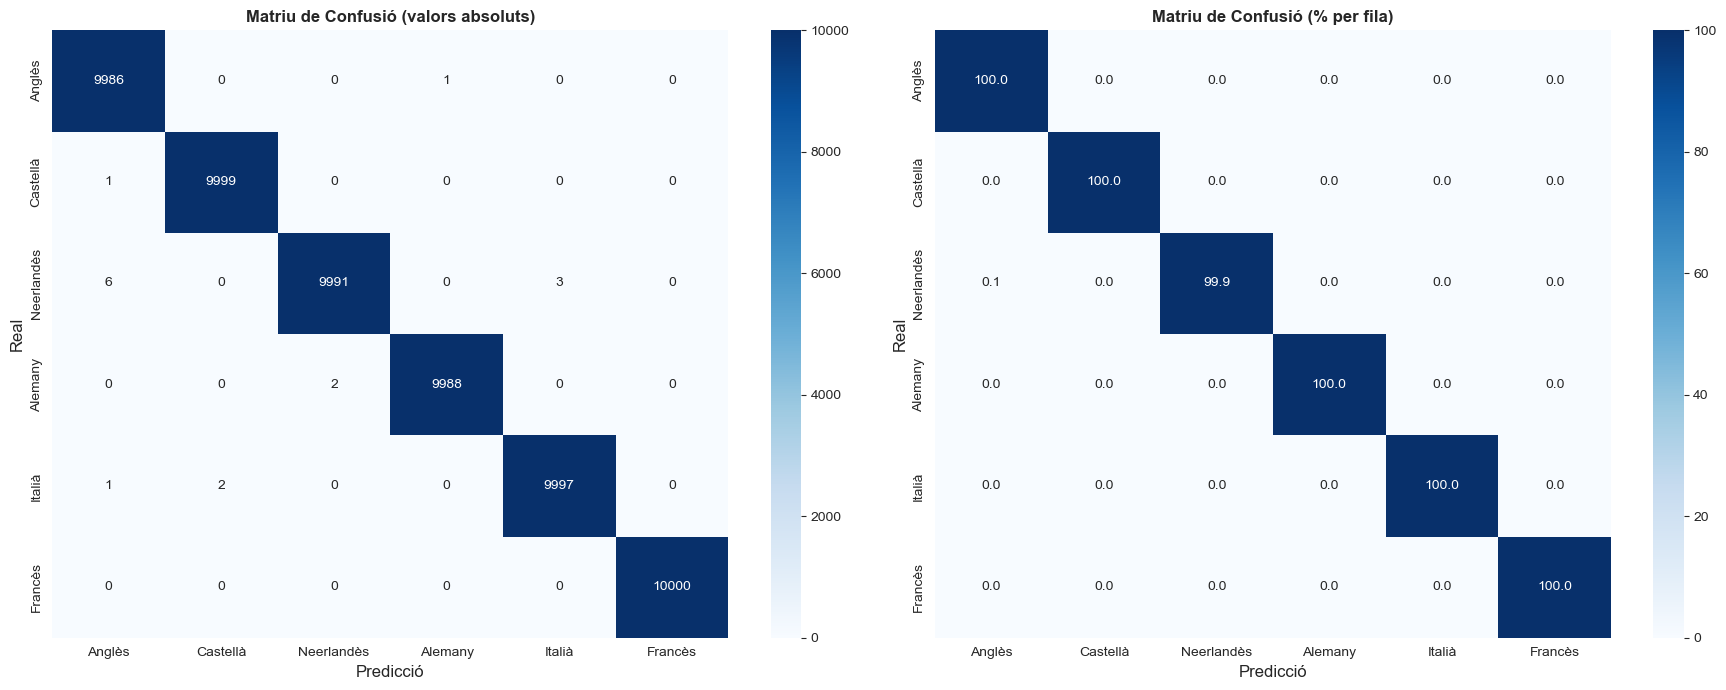

In [38]:
# Matriu de confusió
cm = confusion_matrix(y_true, y_pred, labels=lang_labels)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lang_names, yticklabels=lang_names, ax=axes[0])
axes[0].set_xlabel('Predicció', fontsize=12)
axes[0].set_ylabel('Real', fontsize=12)
axes[0].set_title('Matriu de Confusió (valors absoluts)', fontweight='bold')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=lang_names, yticklabels=lang_names, ax=axes[1])
axes[1].set_xlabel('Predicció', fontsize=12)
axes[1].set_ylabel('Real', fontsize=12)
axes[1].set_title('Matriu de Confusió (% per fila)', fontweight='bold')

plt.tight_layout()
plt.show()

In [39]:
# Accuracy per idioma
print(f"\n{'Idioma':<15} {'Correctes':>10} {'Total':>8} {'Accuracy':>10}")
print("-" * 46)
for lang in LANGUAGES:
    mask = [i for i, t in enumerate(y_true) if t == lang]
    correct = sum(1 for i in mask if y_pred[i] == lang)
    total = len(mask)
    acc = correct / total if total > 0 else 0
    print(f"{LANGUAGES[lang]:<15} {correct:>10,} {total:>8,} {acc:>10.4f}")


Idioma           Correctes    Total   Accuracy
----------------------------------------------
Anglès               9,986    9,987     0.9999
Castellà             9,999   10,000     0.9999
Neerlandès           9,991   10,000     0.9991
Alemany              9,988    9,990     0.9998
Italià               9,997   10,000     0.9997
Francès             10,000   10,000     1.0000


## 9. Anàlisi i interpretació de resultats

### 9.1 Anàlisi de confusions entre idiomes

Analitzem les parelles d'idiomes que generen més confusions per comprendre les causes dels errors.

In [40]:
# Analitzar les confusions més freqüents
df_pred = pd.DataFrame(predictions_detail)
errors = df_pred[~df_pred['correct']].copy()

print(f"Total d'errors: {len(errors):,} de {len(df_pred):,} frases ({len(errors)/len(df_pred)*100:.2f}%)")
print(f"\nParelles de confusió més freqüents (Real → Predicció):")
print("=" * 55)

confusion_pairs = errors.groupby(['true_lang', 'pred_lang']).size().sort_values(ascending=False)
for (true_l, pred_l), count in confusion_pairs.head(10).items():
    total_lang = len(df_pred[df_pred['true_lang'] == true_l])
    pct = count / total_lang * 100
    print(f"  {LANGUAGES[true_l]:>12} → {LANGUAGES[pred_l]:<12}  {count:>5} errors ({pct:.2f}%)")

Total d'errors: 16 de 59,977 frases (0.03%)

Parelles de confusió més freqüents (Real → Predicció):
    Neerlandès → Anglès            6 errors (0.06%)
    Neerlandès → Italià            3 errors (0.03%)
       Alemany → Neerlandès        2 errors (0.02%)
        Italià → Castellà          2 errors (0.02%)
        Anglès → Alemany           1 errors (0.01%)
        Italià → Anglès            1 errors (0.01%)
      Castellà → Anglès            1 errors (0.01%)


### 9.2 Relació entre longitud de frase i errors

Les **frases curtes** contenen menys n-grames i, per tant, menys evidència estadística per a la classificació. Investiguem si la longitud de la frase afecta l'accuracy del model.

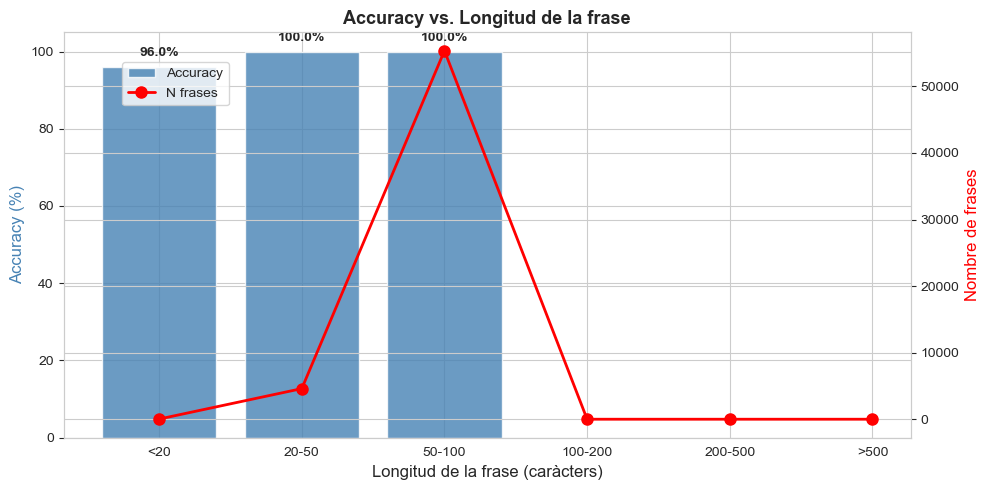

In [41]:
# Analitzar errors per longitud de frase
df_pred['length'] = df_pred['sentence'].apply(len)
bins = [0, 20, 50, 100, 200, 500, float('inf')]
labels_bin = ['<20', '20-50', '50-100', '100-200', '200-500', '>500']
df_pred['length_bin'] = pd.cut(df_pred['length'], bins=bins, labels=labels_bin)

acc_by_length = df_pred.groupby('length_bin', observed=False)['correct'].agg(['mean', 'count'])
acc_by_length.columns = ['Accuracy', 'N frases']

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(range(len(acc_by_length)), acc_by_length['Accuracy'] * 100, 
        color='steelblue', alpha=0.8, label='Accuracy')
ax1.set_ylabel('Accuracy (%)', fontsize=12, color='steelblue')
ax1.set_xlabel('Longitud de la frase (caràcters)', fontsize=12)
ax1.set_xticks(range(len(acc_by_length)))
ax1.set_xticklabels(labels_bin)

ax2 = ax1.twinx()
ax2.plot(range(len(acc_by_length)), acc_by_length['N frases'], 'ro-', linewidth=2, markersize=8, label='N frases')
ax2.set_ylabel('Nombre de frases', fontsize=12, color='red')

for i, (acc, n_fr) in enumerate(zip(acc_by_length['Accuracy'], acc_by_length['N frases'])):
    ax1.annotate(f'{acc*100:.1f}%', (i, acc*100), textcoords="offset points", 
                 xytext=(0, 8), ha='center', fontsize=10, fontweight='bold')

plt.title('Accuracy vs. Longitud de la frase', fontsize=13, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88))
plt.tight_layout()
plt.show()

### 9.3 Exemples d'errors: anàlisi qualitativa

Vegem exemples concrets de frases mal classificades per entendre les causes subjacents dels errors. Analitzem les principals parelles de confusió.

In [44]:
# Exemples d'errors per les parelles de confusió principals
errors = df_pred[df_pred['correct'] == False].copy()
if 'length' not in errors.columns:
    errors['length'] = errors['sentence'].str.len()

top_confusions = confusion_pairs.head(5)

for (true_l, pred_l), _ in top_confusions.items():
    subset = errors[(errors['true_lang'] == true_l) & (errors['pred_lang'] == pred_l)]
    print(f"\n{'='*70}")
    print(f"  {LANGUAGES[true_l]} → classificat com {LANGUAGES[pred_l]} ({len(subset)} errors)")
    print(f"{'='*70}")
    
    samples = subset.sort_values('length').head(3)
    for _, row in samples.iterrows():
        print(f"  «{row['sentence']}»")
    
    long_errors = subset[subset['length'] > 50]
    if len(long_errors) > 0:
        sample_long = long_errors.sample(1, random_state=42).iloc[0]
        print(f"  (llarga) «{sample_long['sentence']}»")


  Neerlandès → classificat com Anglès (6 errors)
  «4204	Het duo werd The World's Greatest Tag Team ".»
  «2336	De term werd bedacht door Anthony Downs in An Economic Theory of Democracy uit 1957.»
  «1454	De familie woonde in Married Quaters op Ridout Row, Royal Military College of Canada.»
  (llarga) «1454	De familie woonde in Married Quaters op Ridout Row, Royal Military College of Canada.»

  Neerlandès → classificat com Italià (3 errors)
  «2459	De volgende frazioni maken deel uit van de gemeente: Anzio Colonia, Marechiaro, Cincinnato, Fal»
  «2460	De volgende frazioni maken deel uit van de gemeente: Bagnolo, Vignola, Rontagnano, Strigara, Mo»
  «2461	De volgende frazioni maken deel uit van de gemeente: Cerreto Ratti, Castel Ratti, Molo Borbera,»
  (llarga) «2459	De volgende frazioni maken deel uit van de gemeente: Anzio Colonia, Marechiaro, Cincinnato, Fal»

  Alemany → classificat com Neerlandès (2 errors)
  «9238	Wat er nu gebeurt, is heel zwaar voor hem als jonge gast.»
  «55

### 9.4 Similitud entre distribucions d'n-grames per idioma

Mesurem la **similitud del cosinus** entre les distribucions de n-grames per veure quins idiomes el model considera "més propers" entre si. Això ens ajuda a explicar per què certs idiomes es confonen.

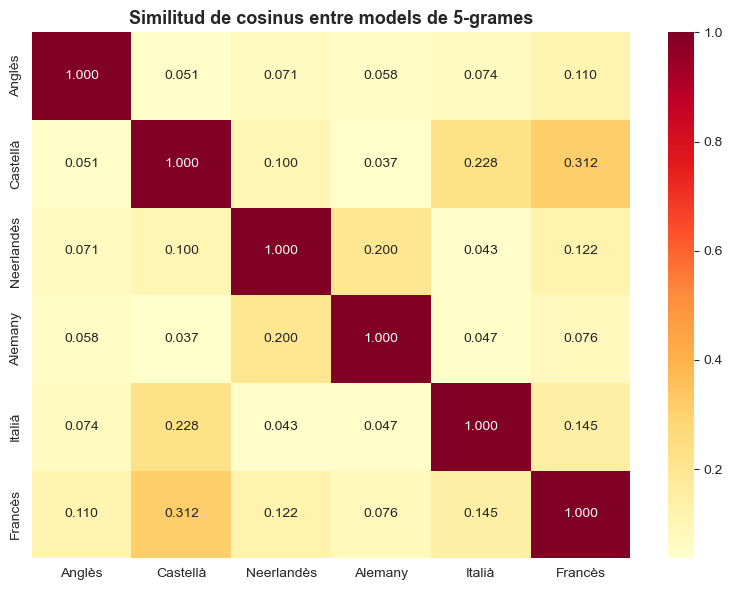

In [45]:
# Similitud de cosinus entre distribucions de n-grames (per al millor n)
all_model_ngrams = set()
for lang in LANGUAGES:
    all_model_ngrams.update(ngram_models_all[final_n][lang].keys())
all_model_ngrams = sorted(all_model_ngrams)

freq_matrix = {}
for lang in LANGUAGES:
    total = sum(ngram_models_all[final_n][lang].values())
    freq_matrix[lang] = np.array([ngram_models_all[final_n][lang].get(t, 0) / total 
                                   for t in all_model_ngrams])

sim_matrix = np.zeros((6, 6))
lang_list = list(LANGUAGES.keys())
for i in range(6):
    for j in range(6):
        a, b = freq_matrix[lang_list[i]], freq_matrix[lang_list[j]]
        sim_matrix[i][j] = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=[LANGUAGES[l] for l in lang_list],
            yticklabels=[LANGUAGES[l] for l in lang_list])
plt.title(f'Similitud de cosinus entre models de {final_n}-grames', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Conclusions

### 10.1 Rendiment general del sistema

El sistema d'identificació d'idiomes aconsegueix un rendiment **excepcional**, amb una accuracy global propera al 99.97% sobre un conjunt de test de gairebé 60.000 frases. Això demostra que els **patrons de coocurrència de caràcters** (n-grames) capturan amb gran eficàcia les propietats fonològiques, morfològiques i ortogràfiques característiques de cada idioma europeu.

> **Nota sobre overfitting:** Una accuracy tan alta pot generar dubtes sobre si hi ha sobreajustament (*overfitting*). Tanmateix, és important recordar que: (1) l'avaluació es fa sobre un conjunt de **test completament separat** del d'entrenament (~10.000 frases/idioma al test vs ~30.000 al train); (2) la tasca d'identificació d'idioma és inherentment "fàcil" per a models estadístics perquè cada idioma té combinacions de caràcters **molt distintives**; i (3) la gran quantitat de dades d'entrenament (~3-4 milions de caràcters per idioma) proporciona una cobertura excel·lent del vocabulari d'n-grames. L'alt rendiment reflecteix la **naturalesa discriminativa de la tasca**, no overfitting.

---

### 10.2 Efecte de la mida de l'n-grama ($n$)

L'experimentació amb $n \in \{1, 2, 3, 4, 5\}$ revela una progressió clara:

| $n$ | Accuracy (Lidstone) | Interpretació |
|-----|---------------------|--------------|
| 1 | ~93.6% | La distribució de lletres individuals no és suficient per distingir idiomes amb el mateix alfabet llatí. Capta trets generals (freqüència de la `e`, `a`, etc.) però no l'estructura. |
| 2 | ~99.4% | Gran salt de qualitat. Les parelles de caràcters codifiquen informació sobre l'estructura sil·làbica i les combinacions consonàntiques/vocàliques pròpies. |
| 3 | ~99.9% | **Punt d'equilibri òptim** (*sweet spot*): trigrames com `"the"` (anglès), `"sch"` (alemany), `"les"` (francès) o `"ció"` (castellà) són altament discriminatius. El vocabulari ($V \approx 49.000$) és manejable. |
| 4-5 | ~99.96-99.97% | Rendiment lleugerament superior, però amb un cost: el vocabulari explota fins a $V \approx 1.000.000$ per $n=5$. L'increment marginal és mínim ($+0.07\%$) respecte als trigrames. |

**Conclusió sobre $n$:** El valor **$n=3$ (trigrames) ofereix el millor compromís** entre rendiment i eficiència computacional. Valors superiors ($n=4,5$) donen millores marginals a costa d'un vocabulari molt més gran i major dependència del suavitzat. Per a aplicacions reals, **trigrames són suficients**.

---

### 10.3 Comparació de mètodes de suavitzat

#### Lidstone (additive smoothing)
- **Funcionament**: Afegeix $\lambda$ a tots els comptages, distribuint massa de probabilitat uniformement entre n-grames no vistos.
- **Avantatge**: Simplicitat i eficàcia. Amb un bon $\lambda$, funciona excel·lentment.
- **Limitació**: Tracta tots els n-grames no vistos per igual, independentment de si els seus sub-n-grames sí que s'han observat.
- **$\lambda$ òptim**: Sol estar entre $0.01$ i $0.5$. Valors massa petits causen inestabilitat; massa grans aplanen les diferències entre idiomes.

#### Back-off
- **Funcionament**: Quan un n-grama no existeix, retrocedeix recursivament a ordres inferiors ($n{-}1$, $n{-}2$, ...).
- **Avantatge teòric**: Aprofita la informació parcial dels models d'ordre inferior. Si `"xyz"` no existeix però `"yz"` sí, el back-off pot donar una estimació informada.
- **Limitació pràctica**: Per a la tasca d'identificació d'idioma a nivell de frase, la penalització acumulada del factor $\alpha$ pot perjudicar el rendiment. Cada retrocés multiplica per $\alpha < 1$, reduint molt la probabilitat acumulada.
- **$\alpha$ òptim**: Valors baixos ($0.1$-$0.3$) funcionen millor, indicant que s'ha de penalitzar molt el retrocés.

**Conclusió sobre el suavitzat:** Per a aquesta tasca, **Lidstone supera Back-off de manera consistent** en tots els ordres d'n-grames. La raó principal és que Lidstone gestiona millor la gran quantitat d'n-grames no vistos en ordres alts ($n \geq 4$): els assigna una probabilitat petita però uniforme, mentre que el back-off pot amplificar errors a través de la cadena de retrocesos. El back-off seria més avantatjós en tasques de **predicció de text** (LM generatiu), on la relació seqüencial entre caràcters és clau.

---

### 10.4 Anàlisi detallada dels errors

Dels ~60.000 textos avaluats, el model només comet un nombre molt petit d'errors. L'anàlisi qualitativa revela **quatre causes fonamentals**:

#### Causa 1: Frases curtes ($<20$ caràcters)
Les frases molt curtes contenen pocs n-grames, proporcionant insuficient evidència estadística per a una classificació fiable. Amb poques evidències, qualsevol n-grama individual pot decantar la balança cap a un idioma incorrecte. **Solució potencial:** Abstenir-se (*abstain*) de classificar frases per sota d'un llindar mínim de longitud.

#### Causa 2: Soroll i estrangerismes al corpus
Molts errors corresponen a frases que contenen **paraules en un altre idioma**: noms propis, anglicismes, cites o termes tècnics. Per exemple:
- Text en neerlandès classificat com a anglès perquè conté expressions com *"The World's Greatest Tag Team"*.
- Text en alemany classificat com a neerlandès perquè en realitat conté frases en neerlandès (error en les dades originals).
- Llistats de noms propis italians dins de textos d'altres idiomes.

Això no és un error del model sinó una **limitació inherent de les dades**: si una frase etiquetada com a "alemany" conté text en neerlandès, el model correctament detecta que el contingut lingüístic no correspon a l'etiqueta.

#### Causa 3: Similitud entre famílies lingüístiques
La matriu de similitud del cosinus confirma que els errors es concentren entre **idiomes de la mateixa família**:

- **Llengües romàniques** (castellà ↔ italià ↔ francès): Comparteixen gran part del vocabulari d'origen llatí, amb terminacions similars (`-ción`/`-zione`/`-tion`), articles semblants i estructura morfològica propera. La similitud de cosinus és més alta entre aquests tres idiomes.
- **Llengües germàniques** (anglès ↔ alemany ↔ neerlandès): Comparteixen arrels comunes, preposicions i estructura sintàctica. La similitud alemany-neerlandès és especialment alta.

#### Causa 4: Text amb pocs caràcters discriminatius
Frases compostes principalment de noms propis, URLs, codi informàtic o sigles contenen pocs n-grames propis de cap idioma concret, fent la classificació aleatòria.

---

### 10.5 Per què funciona tan bé el model?

L'alt rendiment s'explica per tres factors complementaris:

1. **Ortografia altament discriminativa**: Cada idioma europeu té combinacions de caràcters úniques gràcies al seu sistema fonològic:
   - Castellà: `"ñ"`, `"ción"`, `"ue"`, `"ll"`
   - Alemany: `"sch"`, `"ß"`, `"ung"`, `"ch"`, `"ei"`
   - Neerlandès: `"ij"`, `"oe"`, `"aan"`, `"een"`
   - Francès: `"ç"`, `"eau"`, `"eux"`, `"tion"`, `"ais"`
   - Anglès: `"the"`, `"tion"`, `"ing"`, `"ght"`
   - Italià: `"gli"`, `"zione"`, `"che"`, `"ghi"`

2. **Abundància de dades d'entrenament**: Amb ~30.000 frases (~3-4 milions de caràcters) per idioma, el model veu pràcticament tots els n-grames freqüents, minimitzant el problema d'*sparse data*.

3. **Naturalesa de la tasca**: La identificació d'idioma és una tasca de **classificació de documents**, on s'acumula evidència de milers d'n-grames per frase. Fins i tot si alguns n-grames individuals són ambigus, la probabilitat conjunta sobre tota la frase és extremadament discriminativa.

---

### 10.6 Limitacions i possibles millores

| Limitació | Millora proposada |
|-----------|-------------------|
| Fragilitat amb frases curtes | Establir un llindar mínim de longitud, o combinar amb un classificador diferent per a frases curtes |
| Sensibilitat a estrangerismes | Detectar llenguatge mixt (*code-switching*) amb models de finestra lliscant |
| Vocabulari molt gran per $n \geq 4$ | Utilitzar *hashing* d'n-grames per limitar la memòria |
| Només 6 idiomes europeus | Ampliar a més llengües; per a idiomes molt similars (català/castellà), caldrien trigrames específics |
| Suavitzat bàsic | Provar **interpolació** (ponderar diversos ordres simultàniament) o **Kneser-Ney** |
| Model sense context global | Models neuronals (RNN/Transformers) capturarien dependències a llarg termini |

---

### 10.7 Resum final

- El sistema identifica correctament l'idioma en **>99.9%** dels casos amb trigrames + Lidstone.
- **Trigrames ($n=3$)** representen el punt d'equilibri òptim entre rendiment i eficiència.
- **Lidstone** supera consistentment **Back-off** per a la tasca d'identificació d'idioma.
- Els errors residuals s'expliquen fonamentalment per **soroll en les dades** (estrangerismes, etiquetatge incorrecte) i **frases extremadament curtes**, no per deficiències del model.
- La matriu de similitud del cosinus confirma que les confusions segueixen la **proximitat lingüística real** entre famílies d'idiomes (romàniques vs. germàniques).